In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
data_train = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
import numpy as np

train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [5]:
def gen_random_batch(in_groups, batch_halfsize = 8):
  out_img_a, out_img_b, out_score = [], [], []
  all_groups = list(range(len(in_groups)))
  for match_group in [True, False]:
    group_idx = np.random.choice(all_groups, size = batch_halfsize)
    out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]

    if match_group:
      b_group_idx = group_idx
      out_score += [1]*batch_halfsize
    else:
      non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
      b_group_idx = non_group_idx
      out_score += [0]*batch_halfsize

    out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
  return np.array(out_img_a), np.array(out_img_b), np.array(out_score)

a, b, sim = gen_random_batch(train_groups, 3)
a.shape, b.shape, sim.shape

((6, 28, 28), (6, 28, 28), (6,))

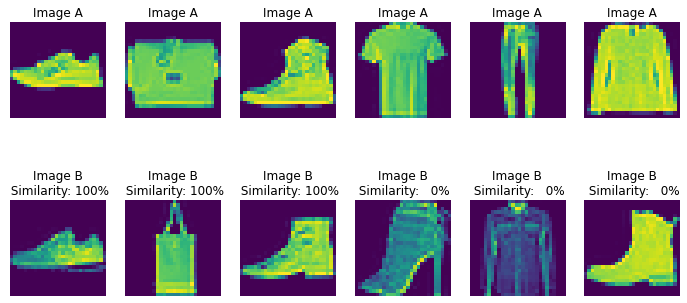

In [6]:
from matplotlib import pyplot as plt

fig, m_axs = plt.subplots(2, a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(a, b, sim, m_axs.T):
  ax1.imshow(c_a)
  ax1.set_title('Image A')
  ax1.axis('off')
  ax2.imshow(c_b)
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
  ax2.axis('off')

In [7]:

img_shape = x_train[0].shape
input = tf.keras.layers.Input(shape=(*img_shape, 1))
xception_model = tf.keras.applications.Xception(
    include_top=False,
    weights=None,
    input_tensor=input,
    pooling='avg'
)

xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 13, 13, 32)   288         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 13, 13, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 13, 13, 32)   0           ['block1_conv1_bn[0][0]'] 

In [8]:
img_a_in = tf.keras.layers.Input(shape=(*img_shape, 1), name='in_a')
img_b_in = tf.keras.layers.Input(shape=(*img_shape, 1), name='in_b')
img_a_feat = xception_model(img_a_in)
img_b_feat = xception_model(img_b_in)
combined_features = tf.keras.layers.concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = tf.keras.layers.Dense(16, activation = 'linear')(combined_features)
combined_features = tf.keras.layers.BatchNormalization()(combined_features)
combined_features = tf.keras.layers.Activation('relu')(combined_features)
combined_features = tf.keras.layers.Dense(4, activation = 'linear')(combined_features)
combined_features = tf.keras.layers.BatchNormalization()(combined_features)
combined_features = tf.keras.layers.Activation('relu')(combined_features)
combined_features = tf.keras.layers.Dense(1, activation = 'sigmoid')(combined_features)

similarity_model = tf.keras.Model(inputs = [img_a_in, img_b_in], outputs=[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_a (InputLayer)              [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 in_b (InputLayer)              [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 xception (Functional)          (None, 2048)         20860904    ['in_a[0][0]',                   
                                                                  'in_b[0][0]']                   
                                                                                                  
 merge_features (Concatenate)   (None, 4096)         0           ['xception[0][0]',

In [9]:
similarity_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['mae'])

callbacks_ = [
  tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=1,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
  ),
  tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', 
      factor=0.2,
      patience=1, 
      min_lr=1e-4
  )
]

print(f'Train: X={x_train.shape} Y={y_train.shape}')
print(f'Train: X={x_test.shape} Y={y_test.shape}')

Train: X=(60000, 28, 28) Y=(60000,)
Train: X=(10000, 28, 28) Y=(10000,)


In [10]:
train_a, train_b, train_sim = gen_random_batch(train_groups, x_train.shape[0]//2)
test_a, test_b, test_sim = gen_random_batch(test_groups, x_test.shape[0]//2)

loss_history = similarity_model.fit(
    [train_a, train_b],
    train_sim,
    validation_data=([test_a, test_b], test_sim),
    batch_size=100,
    epochs=20,
    callbacks=callbacks_
)

Epoch 1/20
600/600 [==============================] - 84s 110ms/step - loss: 0.3754 - mae: 0.2645 - val_loss: 0.2996 - val_mae: 0.1665 - lr: 0.0010
Epoch 2/20
600/600 [==============================] - 64s 107ms/step - loss: 0.2422 - mae: 0.1555 - val_loss: 0.2597 - val_mae: 0.1391 - lr: 0.0010
Epoch 3/20
600/600 [==============================] - 64s 106ms/step - loss: 0.2024 - mae: 0.1262 - val_loss: 0.2273 - val_mae: 0.1288 - lr: 0.0010
Epoch 4/20
600/600 [==============================] - 64s 106ms/step - loss: 0.1771 - mae: 0.1081 - val_loss: 0.2089 - val_mae: 0.1084 - lr: 0.0010
Epoch 5/20
600/600 [==============================] - 64s 106ms/step - loss: 0.1618 - mae: 0.0982 - val_loss: 0.2066 - val_mae: 0.1052 - lr: 0.0010
Epoch 6/20
600/600 [==============================] - 63s 106ms/step - loss: 0.1463 - mae: 0.0878 - val_loss: 0.1777 - val_mae: 0.0970 - lr: 0.0010
Epoch 7/20
600/600 [==============================] - 66s 110ms/step - loss: 0.1313 - mae: 0.0790 - val_loss: 0.

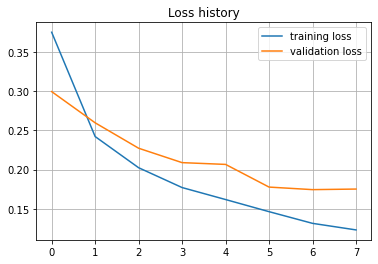

In [11]:
plt.title('Loss history')
plt.plot(loss_history.history['loss'], label = 'training loss')
plt.plot(loss_history.history['val_loss'], label = 'validation loss')
plt.grid()
plt.legend()
plt.show()

In [12]:
def show_results(pv_a, pv_b, pv_sim, pred_sim, no_actual=False):
  fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (2*len(pv_a), 6))
  for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
    ax1.imshow(c_a)
    ax1.set_title('Image A' if no_actual else 'Image A\n Actual: %3.0f%%' % (100*c_d))
    ax1.axis('off')
    ax2.imshow(c_b)
    ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
    ax2.axis('off')

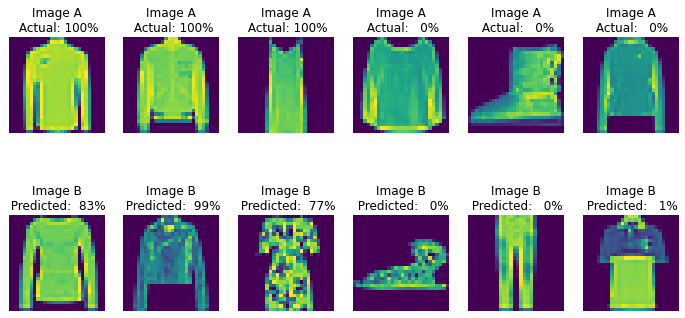

In [13]:
pv_a, pv_b, pv_sim = gen_random_batch(test_groups, 3)
pred_sim = similarity_model.predict([pv_a, pv_b])
show_results(pv_a, pv_b, pv_sim, pred_sim)

In [15]:
x_test_features = xception_model.predict(x_test, batch_size=100)

In [16]:
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.017s...
[t-SNE] Computed neighbors for 10000 samples in 8.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.137169
[t-SNE] Computed conditional probabilities in 0.365s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 64.0518646, gradient norm = 0.0041336 (50 iterations in 3.206s)
[t-SNE] Iteration 100: error = 64.3760376, gradient norm = 0.0020190 (50 iterations in 3.014s)
[t-SNE] Iteration 150: error = 64.2501678, gradient norm = 0.0014407 (50 iterations in 2.952s)
[t-SNE] Iteration 200: error = 64.4190979, gradient norm = 0.0009331 (50 iterations in 2.972s)
[t-SNE] Iteration 250: error = 64.5688324, gradient norm = 0.0006751 (50 iterations in 3.030s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.568832
[t-SNE] Iteration 300: error = 1.8981392, gradient norm = 0.0010421 (50 iterations in 3.186s)
[t-SNE] Iteration 350: error = 1.6320803, gradient norm = 0.0004587 (50 iterations in 3.361s)
[t-SNE] Iteration 400: error = 1.5039175, gradient norm = 0.0003103 (50 iterations in 3.382s)
[t-SNE] Iteration 450: error = 1.4062755, gradient norm = 0.0002399 (50 iterations in 3.319s)
[t-SNE] Iteration 500: error = 1.3284776, gradient norm = 0.0001823 (50 

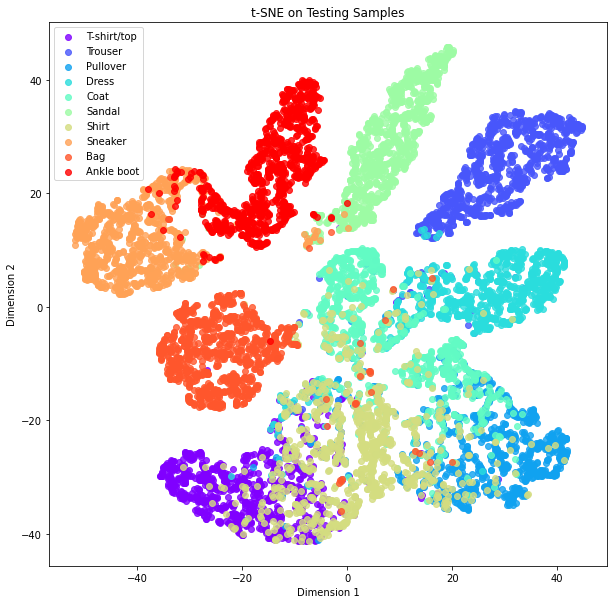

In [17]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
      tsne_features[np.where(y_test == c_group), 0],
      tsne_features[np.where(y_test == c_group), 1],
      marker='o',
      color=c_color,
      linewidth='1',
      alpha=0.8,
      label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show(block=False)